In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times'
mpl.rcParams['figure.facecolor'] = 'w' 
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2  

In [3]:
import src

In [12]:
lrg = src.utils.get_bispectra('LRGz0')
elg = src.utils.get_bispectra('ELGz1')
qso = src.utils.get_bispectra('QSOz2')

tracer: LRGz0, which: all
tracer: ELGz1, which: all
tracer: QSOz2, which: all


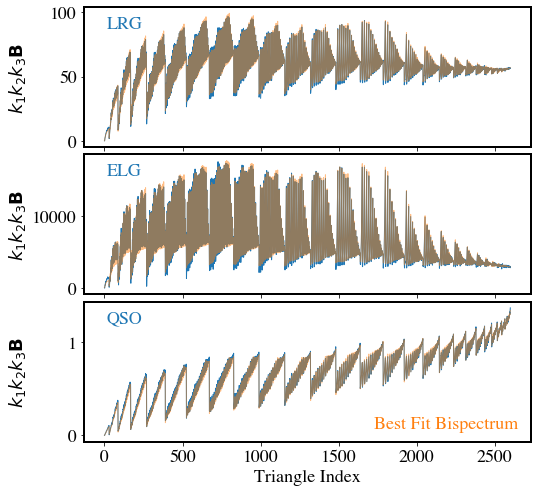

In [9]:
fig, ax = plt.subplots(nrows=3, figsize=(8, 8), sharex=True)
fig.subplots_adjust(hspace=0.05)
for i, (tracer, name) in enumerate(zip([lrg, elg, qso], ['LRG', 'ELG', 'QSO'])):
    k3 = tracer.k[:, 0]*tracer.k[:, 1]*tracer.k[:, 2]
    
    ax[i].plot(k3*tracer.b.mean(axis=0), lw=1, label=name)
    ax[i].plot(k3*tracer.b_bestfit.mean(axis=0), lw=1, alpha=0.5)
    ax[i].annotate(name, (0.05, 0.85), xycoords='axes fraction', color='C0')
    ax[i].set(ylabel=r'$k_{1}k_{2}k_{3}\bf{B}$')
    
ax[2].annotate('Best Fit Bispectrum', (0.65, 0.1), xycoords='axes fraction', color='C1')
ax[2].set_xlabel('Triangle Index')
fig.align_ylabels()
fig.savefig('../bisp4desi/figures/spectra.pdf', bbox_inches='tight')

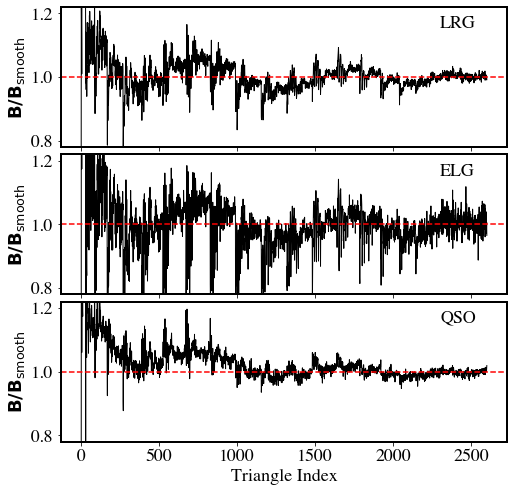

In [41]:
fig, ax = plt.subplots(nrows=3, figsize=(8, 8), sharex=True)
fig.subplots_adjust(hspace=0.05)
for i, (tracer, name) in enumerate(zip([lrg, elg, qso], ['LRG', 'ELG', 'QSO'])):
    k3 = tracer.k[:, 0]*tracer.k[:, 1]*tracer.k[:, 2]
    
    ax[i].plot(tracer.b.mean(axis=0)/tracer.b_smooth.mean(axis=0), lw=1, label=name, color='k')
    ax[i].annotate(name, (0.85, 0.85), xycoords='axes fraction', color='k')
    ax[i].axhline(1.0, ls='--', color='r')
    ax[i].set(ylabel=r'$\bf{B}/\bf{B}_{\rm smooth}$', ylim=(0.78, 1.22))
ax[2].set_xlabel('Triangle Index')
fig.align_ylabels()
fig.savefig('../bisp4desi/figures/spectra_ratio.pdf', bbox_inches='tight')

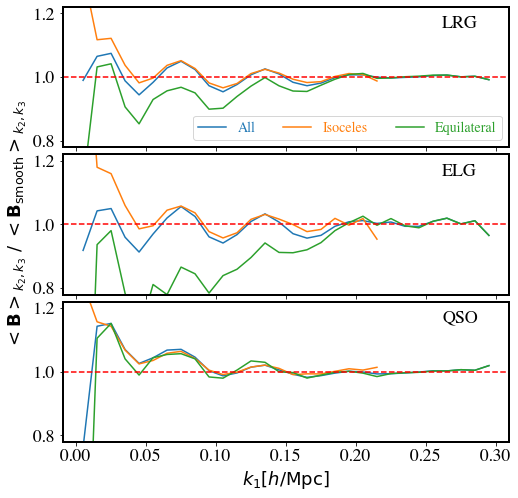

In [42]:
fig, ax = plt.subplots(nrows=3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05)
for i, (tracer, name) in enumerate(zip([lrg, elg, qso], ['LRG', 'ELG', 'QSO'])):
    
    ax[i].plot(tracer.k_all, tracer.b_all.mean(axis=0)/tracer.bs_all.mean(axis=0), label='All')
    ax[i].plot(tracer.k_iso, tracer.b_iso.mean(axis=0)/tracer.bs_iso.mean(axis=0), label='Isoceles')    
    ax[i].plot(tracer.k_eqi, tracer.b_eqi.mean(axis=0)/tracer.bs_eqi.mean(axis=0), label='Equilateral') 
    
    ax[i].annotate(name, (0.85, 0.85), xycoords='axes fraction', color='k')
    ax[i].axhline(1.0, ls='--', color='r')
ax[1].set(ylabel=r'$<{\bfB}>_{k_{2},k_{3}}~/~<{\bf B}_{\rm smooth}>_{k_{2},k_{3}}$', ylim=(0.78, 1.22))
ax[2].set_xlabel(r'$k_{1} [h/{\rm Mpc}]$')
legend = ax[0].legend(loc=4, fontsize=14, ncol=3)
for i,txt in enumerate(legend.get_texts()):
    txt.set_color('C%d'%i)
fig.align_ylabels()

fig.savefig('../bisp4desi/figures/spectra_ratio_reduced.pdf', bbox_inches='tight')

In [43]:
n = np.loadtxt('/Users/mehdi/data/AbacusData/bk_LRGz0.8000')
d = np.loadtxt('/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8000.txt')
d.shape, n.shape

((2600, 6), (2600, 6))

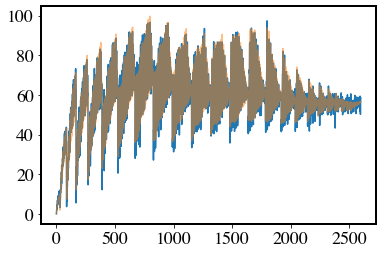

In [44]:
plt.plot(n[:, 0]*n[:, 1]*n[:, 2]*n[:, 3])
plt.plot(d[:, 0]*d[:, 1]*d[:, 2]*d[:, 4], alpha=0.5)

In [45]:
import src

from glob import glob
from scipy.optimize import minimize
from multiprocessing.pool import ThreadPool as Pool

In [4]:
class Posterior:
    
    def __init__(self, k, r, KMIN=0.025, KMAX=0.250):        
        self.k = k
        self.r = r
        self.sp = src.models.BiSpectrum(self.k, self.r)
        is_g = (self.k > KMIN) & (self.k < KMAX)
        self.is_g = is_g.sum(axis=1) == 3
        
    def __call__(self, p):
        return self.nlogpost(p)
        
    def loglike(self, p):
        residual = self.r[self.is_g] - self.sp(self.k[self.is_g], p)
        is_ok = ~np.isnan(residual)    
        if is_ok.sum() == 0:
            return -np.inf
        else:
            return -0.5*(residual[is_ok]*residual[is_ok]).sum()

    def logprior(self, p):
        lp = 0.
        lp += 0. if  0.9 < p[0] < 1.1 else -np.inf
        lp += 0. if  0.8 < p[1] < 1.2 else -np.inf    
        for p_i in p[2:]:
            lp += 0. if  -1000. < p_i < 1000. else -np.inf
        return lp

    def logpost(self, p):
        return self.logprior(p) + self.loglike(p)

    def nlogpost(self, p):
        return -1.*self.logpost(p)

In [5]:
(k_all, rbin_all, rvar_all), (k, r) = src.utils.get_data(True)

which: all
r.shape: (25, 30)


Text(0, 0.5, 'Bispectrum ratio')

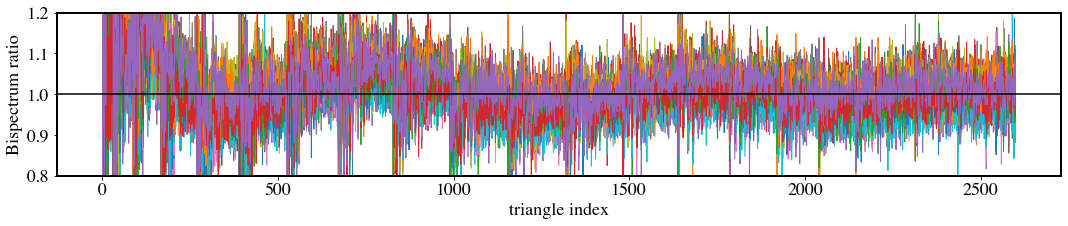

In [6]:
plt.figure(figsize=(18, 3))
plt.plot(r.T, lw=1)
# plt.plot(np.median(r, axis=0))
# plt.plot(np.mean(r, axis=0))
plt.ylim(0.8, 1.2)
plt.axhline(1.0, color='k')
plt.xlabel('triangle index')
plt.ylabel('Bispectrum ratio')

In [7]:
i = 13 # mock -8013
r_obs = rbin_all[i]
sp = src.models.BiSpectrum(k, r.mean(axis=0)) # mean of 25 realization as the model 

In [75]:
def loglike(p, kmin=0.00, kmax=0.4):  
    r_model = sp(k, p)
    is_finite = np.isfinite(r_model)  
    if is_finite.sum()==0:
        return -np.inf
    
    k_bin, r_model_bin = src.utils.bin_bispectrum(k[is_finite], r_model[is_finite])
    k_ix = ((k_bin - k.min()+1.0e-8)/0.01).astype('int')
    residual = (r_model_bin - r_obs[k_ix])
    
    is_good = (k_bin > kmin) & (k_bin < kmax)
    chi2 = ((residual/rvar_all[k_ix])**2)[is_good]
    is_finite = ~np.isnan(chi2)
    if is_finite.sum()==0:
        return -np.inf
                
    return -0.5*chi2[is_finite].sum()

def logprior(p):
    lp = 0.
    lp += 0. if  0.8 < p[0] < 1.2 else -np.inf
    lp += 0. if  0.5 < p[1] < 2.0 else -np.inf    
    for p_i in p[2:]:
        lp += 0. if  -100. < p_i < 100. else -np.inf
    return lp    

def logpost(p, kmin=0.00, kmax=0.4):
    return loglike(p, kmin=kmin, kmax=kmax) + logprior(p)

In [87]:
from scipy.optimize import minimize

In [90]:
start.shape

(22, 11)

In [104]:
def nlogpost(p, kmin, kmax):
    return -1*logpost(p, kmin, kmax)

In [105]:
res = minimize(nlogpost, start[2], args=(0.04, 0.25))

/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [106]:
res.x # from optimization

array([ 1.01078731e+00,  1.02948644e+00, -5.86273424e+00,  9.03658933e+00,
        3.14273338e-01, -1.04445789e+01,  5.39183681e-03,  2.62919791e+00,
       -2.14058231e-02, -2.88717461e+00, -2.23384490e-02])

In [107]:
start[2] # initial guess

array([ 0.84448608,  1.07264313,  0.12622236,  0.04941727,  0.06532435,
        0.06211021,  0.11285517, -0.02969583,  0.12713781,  0.033162  ,
       -0.01385321])

In [9]:
import emcee

In [108]:
nwalkers = 22
ndim    = 11
nsteps = 1000
cov = 0.001*np.eye(11)
start = np.random.multivariate_normal(res.x, cov, size=nwalkers)

n = 4
with Pool(n) as pool:    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(0.04, 0.25), pool=pool)
    sampler.run_mcmc(start, nsteps, progress=True)

100%|███████████████████████████████████████| 1000/1000 [11:36<00:00,  1.44it/s]


In [109]:
chain = sampler.get_chain()

In [110]:
chain.shape

(1000, 22, 11)

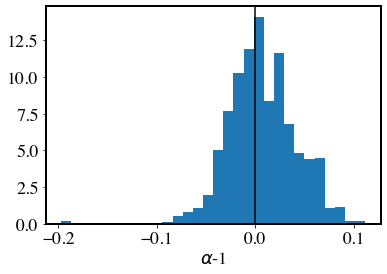

In [111]:
_ = plt.hist(chain[200::10, :, 0].flatten()-1, bins=30, density=True)
plt.xlabel(r'$\alpha$-1')
plt.axvline(0, color='k')

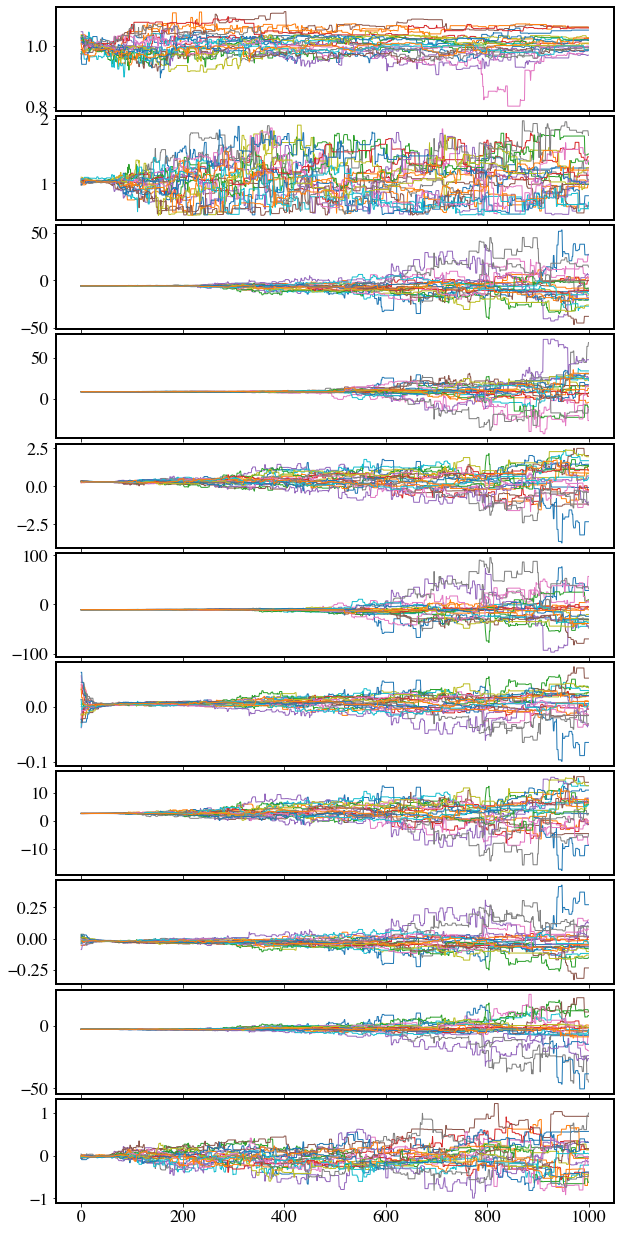

In [112]:
fig, ax = plt.subplots(nrows=11, figsize=(10, 22), sharex=True)
fig.subplots_adjust(hspace=0.05)
for i in range(11):
    ax[i].plot(chain[:, :, i], lw=1)

In [83]:
lk = []
lk1 = []
ps = np.linspace(0.96, 1.04, num=41)
for p in ps:
    lk.append(logpost([p, 1.04]+9*[0.0, ]))
    lk1.append(logpost([p, 1.04]+9*[0.0, ], kmin=0.04, kmax=0.25))

Text(0, 0.5, '$\\chi^{2}$')

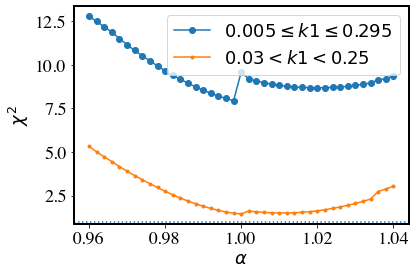

In [86]:
plt.plot(ps, -2*np.array(lk), marker='o', label=r'$0.005\leq k1 \leq 0.295$')
plt.plot(ps, -2*np.array(lk1), marker='.', label=r'$0.03<k1<0.25$')
plt.axhline(1, ls=':')
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^{2}$')

Text(0, 0.5, 'residual')

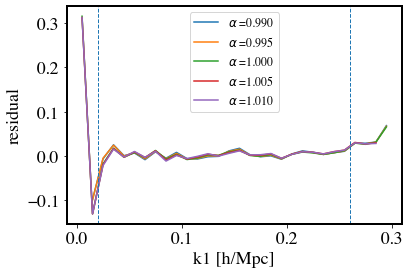

In [263]:
plt.figure()
# plt.errorbar(k_all, r_obs, yerr=rvar_all)

for a in [0.990, 0.995, 1.0, 1.005, 1.01]:
    r_model = sp(k, [a, 1.04]+9*[0.0, ])
    is_finite = np.isfinite(r_model)    
    k_bin, r_model_bin = src.utils.bin_bispectrum(k[is_finite], r_model[is_finite])
    k_ix = ((k_bin - k.min()+1.0e-8)/0.01).astype('int')
    residual = (r_model_bin - r_obs[k_ix])
    plt.plot(k_bin, residual, label=fr'$\alpha$ ={a:.3f}')
    
# plt.ylim(0., 1.2)
for x in [0.02, 0.26]:
    plt.axvline(x, ls='--', lw=1)
plt.legend(fontsize=12)
plt.xlabel('k1 [h/Mpc]')
plt.ylabel('residual')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'residual')

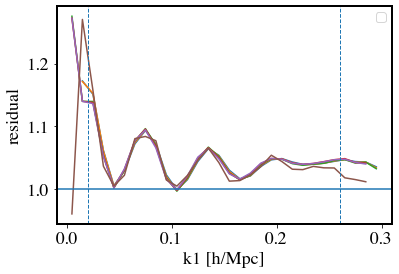

In [262]:
plt.figure()
# plt.errorbar(k_all, r_obs, yerr=rvar_all)

for a in [0.990, 0.995, 1.0, 1.005, 1.01]:
    r_model = sp(k, [a, 1.04]+9*[0.0, ])
    is_finite = np.isfinite(r_model)    
    k_bin, r_model_bin = src.utils.bin_bispectrum(k[is_finite], r_model[is_finite])
    k_ix = ((k_bin - k.min()+1.0e-8)/0.01).astype('int')
    #residual = (r_model_bin - r_obs[k_ix])
    #plt.plot(k_bin, residual, label=fr'$\alpha$ ={a:.3f}')
    plt.plot(k_bin, r_model_bin)
plt.plot(k_bin, r_obs[k_ix])
    
# plt.ylim(0., 1.2)
for x in [0.02, 0.26]:
    plt.axvline(x, ls='--', lw=1)
    
plt.axhline(1)
plt.legend(fontsize=12)
plt.xlabel('k1 [h/Mpc]')
plt.ylabel('residual')

In [226]:
r_obs.shape

(30,)

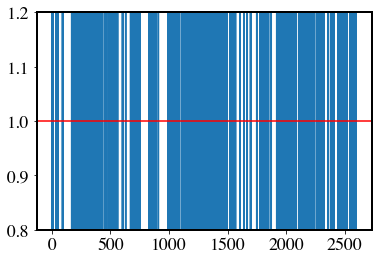

In [254]:
i = 8013
bk_smooth = np.loadtxt(f'/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_{i:d}.txt')
bk = np.loadtxt(f'/Users/mehdi/data/AbacusData/bk_LRGz0.{i:d}')        
plt.plot(bk[:, 3]-bk_smooth[:, 5])
plt.ylim(0.8, 1.2)
plt.axhline(1, color='r')

## Prepare data

In [6]:
k_all, rbin_all, rvar_all = src.utils.get_covariance(True)
k_iso, rbin_iso, rvar_iso = src.utils.get_covariance(True, which='iso')
k_equ, rbin_equ, rvar_equ = src.utils.get_covariance(True, which='equ')

[autoreload of src.utils failed: Traceback (most recent call last):
  File "/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mehdi/miniconda3/envs/sysnet/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_w

which: all
marginalize over k2 & k3 given: [0.   0.01 0.02] ...
r.shape: (25, 30)
which: iso
marginalize over k2 & k3 given: [0.   0.01 0.02] ...
r.shape: (25, 22)
which: equ
marginalize over k2 & k3 given: [0.   0.01 0.02] ...
r.shape: (25, 30)


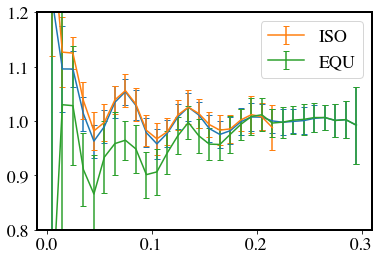

In [5]:
plt.errorbar(k_all, rbin_all.mean(axis=0), yerr=rvar_all, capsize=3)
plt.errorbar(k_iso, rbin_iso.mean(axis=0), yerr=rvar_iso, capsize=3, label='ISO')
plt.errorbar(k_equ, rbin_equ.mean(axis=0), yerr=rvar_equ, capsize=3, label='EQU')
plt.ylim(0.8, 1.2)
plt.legend()

In [ ]:
class Spectrum(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

def read_spectra(spectra, ix=3, iy=3):
    print(len(spectra))

    y = []
    for spec in spectra:
        d_ = np.loadtxt(spec)
        y.append(d_[:, iy])
        
    y = np.array(y)
    x = d_[:, :ix]
    
    return Spectrum(x, y)

class Posterior:
    
    def __init__(self, k, r, KMIN=0.025, KMAX=0.250):        
        self.k = k
        self.r = r
        self.sp = src.models.BiSpectrum(self.k, self.r)
        is_g = (self.k > KMIN) & (self.k < KMAX)
        self.is_g = is_g.sum(axis=1) == 3
        
    def __call__(self, p):
        return self.nlogpost(p)
        
    def loglike(self, p):
        residual = self.r[self.is_g] - self.sp(self.k[self.is_g], p)
        is_ok = ~np.isnan(residual)    
        if is_ok.sum() == 0:
            return -np.inf
        else:
            return -0.5*(residual[is_ok]*residual[is_ok]).sum()

    def logprior(self, p):
        lp = 0.
        lp += 0. if  0.9 < p[0] < 1.1 else -np.inf
        lp += 0. if  0.8 < p[1] < 1.2 else -np.inf    
        for p_i in p[2:]:
            lp += 0. if  -1000. < p_i < 1000. else -np.inf
        return lp

    def logpost(self, p):
        return self.logprior(p) + self.loglike(p)

    def nlogpost(self, p):
        return -1.*self.logpost(p)
    
    
def plot(k_good, bk_good, bk_smooth_good):
    
    kmin, kmax = np.percentile(k_good[:,0], [0, 100])
    bins = np.arange(kmin-0.005, kmax+0.015, 0.01)
    bb, kb, __ = binned_statistic(k_good[:, 0], bk_good.mean(axis=0)/bk_smooth_good.mean(axis=0), bins=bins)
    
    bk_all = []
    for bk_i in bk_good:
        bkm_i, __, __ = binned_statistic(k_good[:, 0], bk_i/bk_smooth_good.mean(axis=0), bins=bins)
        bk_all.append(bkm_i)
    bk_all = np.array(bk_all)
    bk_std = bk_all.std(axis=0)
    print(bk_all.shape)
    km = 0.5*(kb[1:]+kb[:-1])

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    fig.subplots_adjust(wspace=0.01)

    ax[0].scatter(k_good[:, 0], bk_good.mean(axis=0)/bk_smooth_good.mean(axis=0), marker='.', alpha=0.2, label=f'# data: {len(k_good[:, 0])}')
    ax[0].errorbar(km, bb, yerr=bk_std, color='r', ls='None', capsize=3, marker='.')
    ax[1].plot(k_good)

    ax[1].legend(['k1', 'k2', 'k3'])
    ax[0].legend()
    ax[0].set(ylim=(0.8, 1.2), xlabel='k1', ylabel=r'B/B$_{\rm Smooth}$')
    ax[1].set(xlabel='Index', ylabel=r'k$_{i}$')
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.set_ticks_position("right")   
    
    return (km, bb, bk_std)
    
    
def plot2(k_good, bk_good, bk_smooth_good):
    
    kmin, kmax = np.percentile(k_good[:,0], [0, 100])
    bins = np.arange(kmin-0.005, kmax+0.015, 0.01)
    bb, kb, __ = binned_statistic(k_good[:, 0], (bk_good/bk_smooth_good).mean(axis=0), bins=bins)
    
    bk_all = []
    for bk_i in bk_good/bk_smooth_good:
        bkm_i, __, __ = binned_statistic(k_good[:, 0], bk_i, bins=bins)
        bk_all.append(bkm_i)
    bk_all = np.array(bk_all)
    bk_std = bk_all.std(axis=0)
    print(bk_all.shape)
    km = 0.5*(kb[1:]+kb[:-1])

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    fig.subplots_adjust(wspace=0.01)

    ax[0].scatter(k_good[:, 0], (bk_good/bk_smooth_good).mean(axis=0), marker='.', alpha=0.2, label=f'# data: {len(k_good[:, 0])}')
    ax[0].errorbar(km, bb, yerr=bk_std, color='r', ls='None', capsize=3, marker='.')
    ax[1].plot(k_good)

    ax[1].legend(['k1', 'k2', 'k3'])
    ax[0].legend()
    ax[0].set(ylim=(0.8, 1.2), xlabel='k1', ylabel=r'B/B$_{\rm Smooth}$')
    ax[1].set(xlabel='Index', ylabel=r'k$_{i}$')
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.set_ticks_position("right")        


def get_corr(x, y):
    cxy = ((x-x.mean())*(y-y.mean())).sum()
    cxx = ((x-x.mean())*(x-x.mean())).sum()
    cyy = ((y-y.mean())*(y-y.mean())).sum()
    return cxy/np.sqrt(cxx*cyy)

def correlate(r_b, r_p):
    
    corr = np.empty((r_b.shape[1], r_p.shape[1]))*np.nan
    for i in range(r_b.shape[1]):
        for j in range(r_p.shape[1]):
            corr[i, j] = get_corr(r_b[:, i], r_p[:, j])
            
    return corr


def plot_abacus_spectra():
    
    fig, ax = plt.subplots(ncols=3, figsize=(20, 5), sharey=True)
    fig.subplots_adjust(wspace=0.01)

    for i, t in enumerate(['LRG', 'ELG', 'QSO']):

        p_now = read_spectra(np.sort(glob(f'/Users/mehdi/data/Abacus_smooth/all_pk_{t}*')), ix=1, iy=2)
        p_wig = read_spectra(np.sort(glob(f'/Users/mehdi/data/AbacusData/pk_{t}*')), ix=1, iy=1)
        b_now = read_spectra(np.sort(glob(f'/Users/mehdi/data/Abacus_smooth/all_bk_{t}*')), iy=5)
        b_wig = read_spectra(np.sort(glob(f'/Users/mehdi/data/AbacusData/bk_{t}*')))

        r_p = p_wig.y / p_now.y.mean(axis=0)
        #ix_equi = equilateral(b_wig.x)
        #ix_iso = isoceles(b_wig.x)
        r_b = b_wig.y/b_now.y.mean(axis=0)

        k_b, r_bb = bin_bispectra(b_wig.x, r_b)

        ax[i].scatter(b_wig.x[:, 0], r_b.mean(axis=0), marker='.', label='B($k_{1},k_{2},k_{3}$)', alpha=0.2)
        ax[i].scatter(k_b, r_bb.mean(axis=0), label=r'<B($k_{1},k_{2},k_{3}$)>$_{k_{2}k_{3}}$')

        ax[i].scatter(p_wig.x, r_p.mean(axis=0), label='P(k)')
        ax[i].set(xlabel=r'$k$ or $k_{1}$ [$h^{-1}$Mpc]', title=t)

    ax[0].set(ylim=(0.8, 1.2), ylabel='Wiggle to no-Wiggle')
    lgn = ax[2].legend(loc=4, frameon=False, markerfirst=False, labelspacing=0.1,handletextpad=0.0)
    for i, tx in enumerate(lgn.get_texts()):
        tx.set_color('C%d'%i)
    
    fig.savefig('./figs/spectra_abacus.pdf', bbox_inches='tight')
    
    
def plot_corrmax(t = 'LRG'):
    p_now = read_spectra(np.sort(glob(f'/Users/mehdi/data/Abacus_smooth/all_pk_{t}*')), ix=1, iy=2)
    p_wig = read_spectra(np.sort(glob(f'/Users/mehdi/data/AbacusData/pk_{t}*')), ix=1, iy=1)
    b_now = read_spectra(np.sort(glob(f'/Users/mehdi/data/Abacus_smooth/all_bk_{t}*')), iy=5)
    b_wig = read_spectra(np.sort(glob(f'/Users/mehdi/data/AbacusData/bk_{t}*')))

    r_p = p_wig.y / p_now.y.mean(axis=0)
    r_b = b_wig.y/b_now.y.mean(axis=0)
    ix_equi = equilateral(b_wig.x)
    ix_iso = isoceles(b_wig.x)

    k_b, r_b_bin = bin_bispectra(b_wig.x, r_b)
    k_b_iso, r_b_bin_iso = bin_bispectra(b_wig.x[ix_iso, :], r_b[:, ix_iso])
    k_b_equ, r_b_bin_equ = bin_bispectra(b_wig.x[ix_equi, :], r_b[:, ix_equi])

    corr = correlate(r_b_bin, r_p)
    corr_equ = correlate(r_b_bin_equ, r_p)
    corr_iso = correlate(r_b_bin_iso, r_p[:, :22])
    corr_p = correlate(r_p, r_p)

    ix = np.random.permutation(np.arange(25))
    corr_shu = correlate(r_b_bin, r_p[ix, :])

    # because some bins are available
    corr_iso_f = np.zeros((30, 30))*np.nan
    corr_iso_f[:22, :22] = corr_iso

    fig, ax = plt.subplots(ncols=5, figsize=(20, 4), sharey=True)
    fig.subplots_adjust(wspace=0)

    names = ['PxP', 'PxB', 'PxBequi', 'PxBiso', 'PxB [shuffled]']
    for i, ci in enumerate([corr_p, corr, corr_equ, corr_iso_f, corr_shu]):
        print(np.percentile(ci, [0, 100]))
        map_ = ax[i].imshow(ci, origin='lower', vmin=-1, vmax=1., cmap='bwr', extent=[0, 0.3, 0, 0.3])
        ax[i].set_title(names[i])

    ax[0].set_ylabel('k')
    ax[2].set_xlabel('k')    
    cax = fig.add_axes([0.91, 0.2, 0.01, 0.6])
    fig.colorbar(map_, cax=cax, label=r'$\rho$')
    fig.savefig('figs/corr_pb.pdf', bbox_inches='tight')    

In [7]:
tracer = 'LRG'



bk_smooth = read_spectra(glob(f'/Users/mehdi/data/Abacus_smooth/all_bk_{tracer}*'), iy=5)
bk = read_spectra(glob(f'/Users/mehdi/data/AbacusData/bk_{tracer}*'))

25
25


In [11]:
np.sort(glob(f'/Users/mehdi/data/AbacusData/bk_{tracer}*'))

array(['/Users/mehdi/data/AbacusData/bk_LRGz0.8000',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8001',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8002',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8003',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8004',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8005',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8006',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8007',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8008',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8009',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8010',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8011',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8012',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8013',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8014',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8015',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8016',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.8017',
       '/Users/mehdi/data/AbacusData/bk_LRGz0.

In [14]:
np.sort(glob(f'/Users/mehdi/data/Abacus_smooth/all_bk_LRG*'))

array(['/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8000.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8001.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8002.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8003.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8004.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8005.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8006.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8007.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8008.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8009.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8010.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8011.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8012.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8013.txt',
       '/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_8014.txt',
       '/Users/mehdi/data/Abacus_smooth/

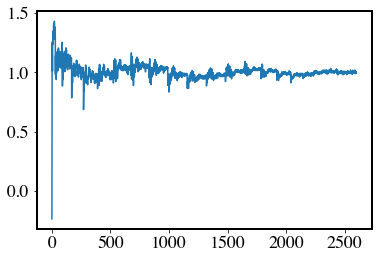

In [9]:
plt.plot(bk.y.mean(axis=0)/bk_smooth.y.mean(axis=0))

25
25
25
25
(25, 30) (30,)
25
25
25
25
(25, 30) (30,)
25
25
25
25
(25, 30) (30,)


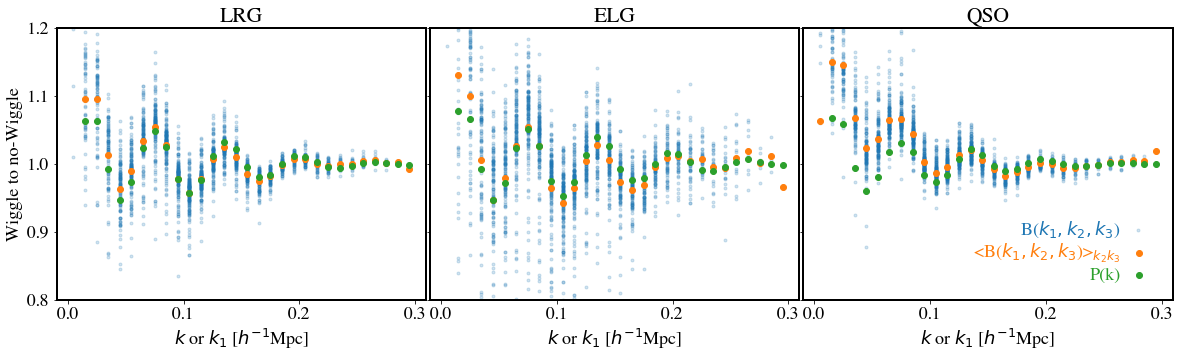

In [7]:
plot_abacus_spectra()

25
25
25
25
(25, 30) (30,)
(25, 22) (22,)
(25, 30) (30,)
[-0.49081954  1.        ]
[-0.59242475  0.93300078]
[-0.59239179  0.6794852 ]
[nan nan]
[-0.59867389  0.58213697]


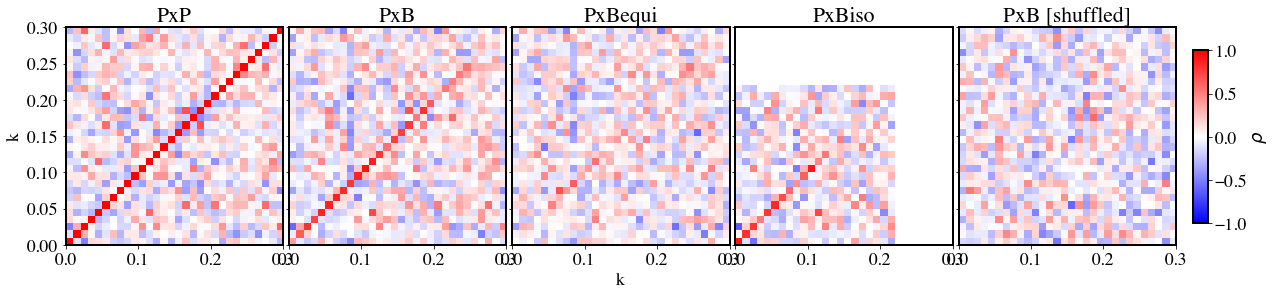

In [9]:
plot_corrmax('LRG')

25
25
25
25
(25, 30) (30,)
(25, 22) (22,)
(25, 30) (30,)
[-0.63678771  1.        ]
[-0.71521793  0.94530243]
[-0.59257361  0.64341254]
[nan nan]
[-0.60073161  0.6127798 ]


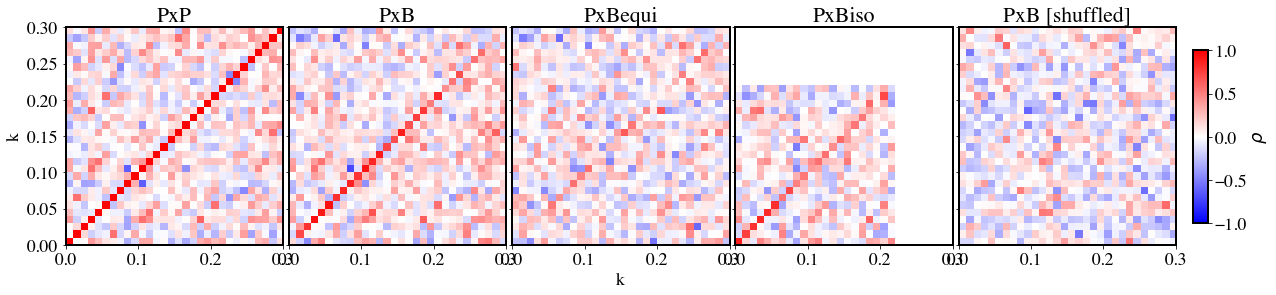

In [10]:
plot_corrmax('QSO')

25
25
25
25
(25, 30) (30,)
(25, 22) (22,)
(25, 30) (30,)
[-0.62785648  1.        ]
[-0.62380258  0.75624358]
[-0.56535431  0.64464469]
[nan nan]
[-0.66489603  0.56501661]


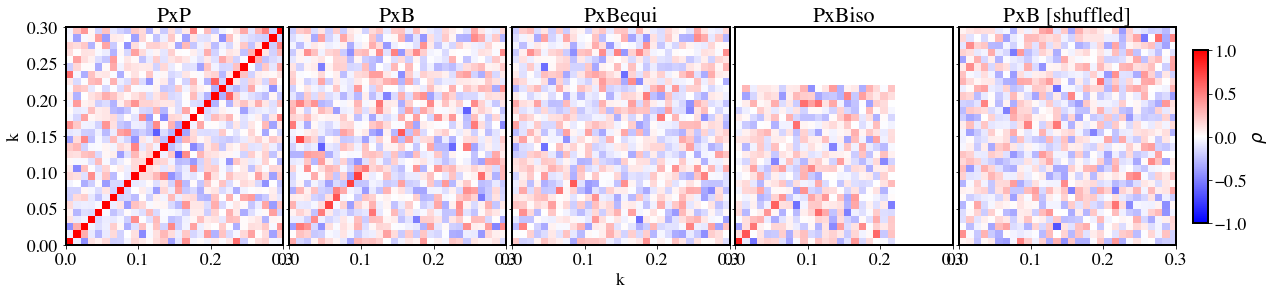

In [11]:
plot_corrmax('ELG')

(25, 30)
(25, 22)
(25, 30)


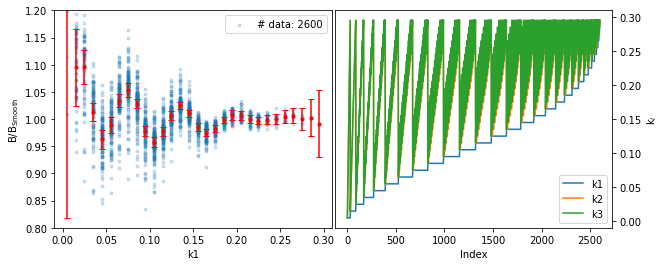

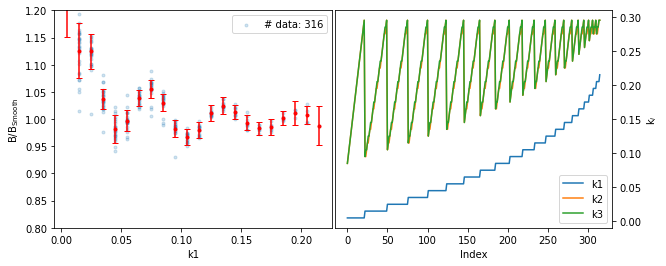

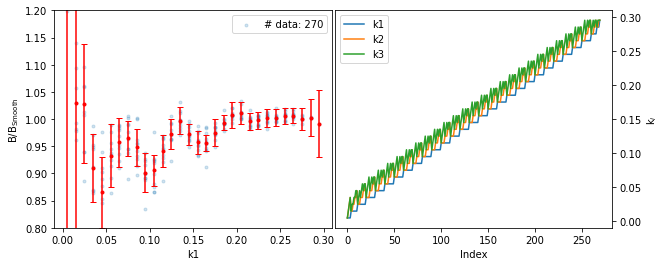

In [26]:
all_bk = plot(b_wig.x, b_wig.y,  b_now.y)
iso_bk = plot(b_wig.x[ix_iso], b_wig.y[:, ix_iso],  b_now.y[:, ix_iso])
eqi_bk = plot(b_wig.x[ix_equi], b_wig.y[:, ix_equi],  b_now.y[:, ix_equi])

Text(0, 0.5, 'BAO')

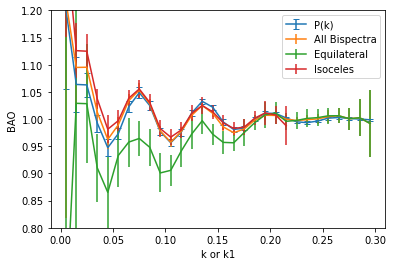

In [27]:
plt.errorbar(p_wig.x, p_wig.y.mean(axis=0)/p_now.y.mean(axis=0), 
             yerr=p_wig.y.std(axis=0)/p_now.y.mean(axis=0), 
             capsize=3, label='P(k)', zorder=-10)

labels = ['All Bispectra', 'Equilateral', 'Isoceles']
for i, bk_i in enumerate([all_bk, eqi_bk, iso_bk]):
    plt.errorbar(*bk_i, zorder=-10, label=labels[i])
    
    #print(np.corrcoef(pbao.y.mean(axis=0)/psmooth.y.mean(axis=0), bk_i[1]))
plt.ylim(0.8, 1.2)
plt.legend()
plt.xlabel('k or k1')
plt.ylabel('BAO')

(25, 30)
(25, 30)


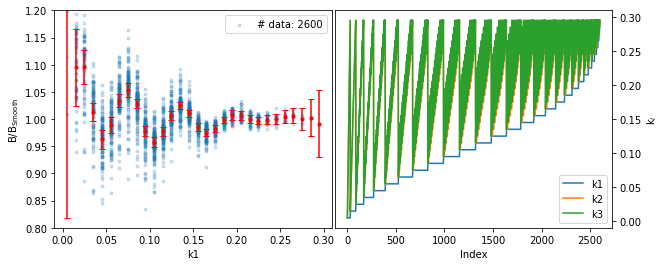

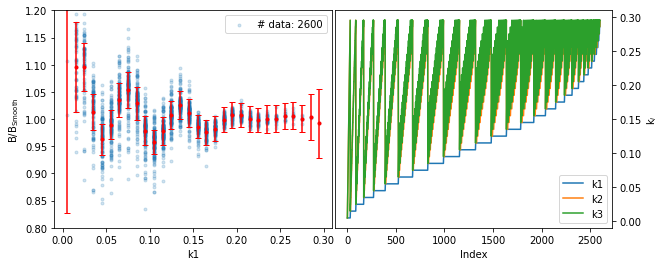

In [61]:
plot(k, bao.y, smooth.y)
plot2(k, bao.y, smooth.y)

(25, 30)
(25, 30)


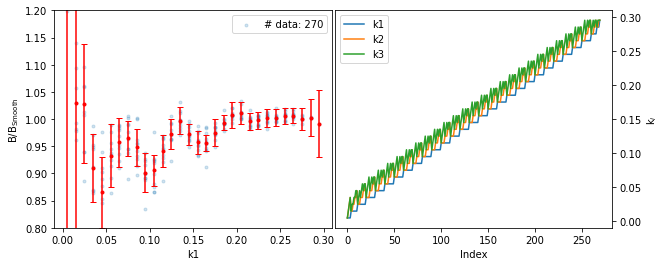

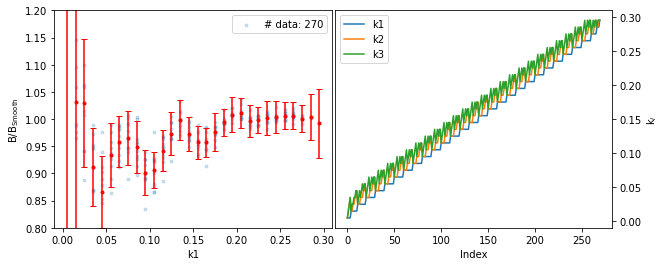

In [59]:
plot(k[ix_equi], bao.y[:, ix_equi], smooth.y[:, ix_equi])
plot2(k[ix_equi], bao.y[:, ix_equi], smooth.y[:, ix_equi])

(25, 22)
(25, 22)


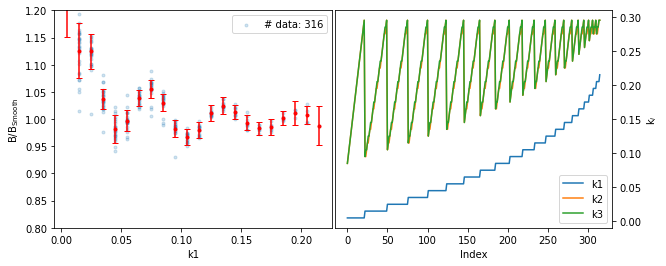

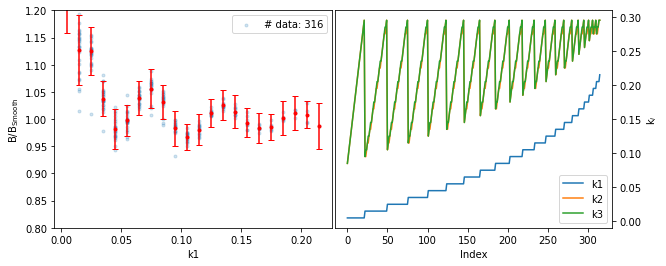

In [60]:
plot(k[ix_iso], bao.y[:, ix_iso], smooth.y[:, ix_iso])
plot2(k[ix_iso], bao.y[:, ix_iso], smooth.y[:, ix_iso])

In [11]:
index = 8000
d = np.loadtxt(f'/Users/mehdi/data/AbacusData/bk_LRGz0.{index}')
#ds = np.loadtxt(f'/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_{index}.txt')
k = d[:, :3]
r = d[:, 3]/smooth.y.mean(axis=0) #ds[:, 5]
lpost = Posterior(k, r)

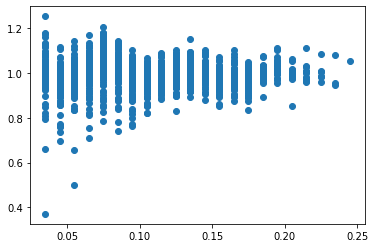

In [12]:
plt.scatter(lpost.k[lpost.is_g, 0], lpost.r[lpost.is_g])

In [47]:
alphas = []

for index in np.arange(8000, 8025):
    
    d = np.loadtxt(f'/Users/mehdi/data/AbacusData/bk_LRGz0.{index}')
    #ds = np.loadtxt(f'/Users/mehdi/data/Abacus_smooth/all_bk_LRGz0_{index}.txt')
    k = d[:, :3]
    r = d[:, 3]/smooth.y.mean(axis=0) #ds[:, 5]
    
    t0 = time()
    lpost = Posterior(k, r)
    result = minimize(lpost, [1.08, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  method='Nelder-Mead')
    t1 = time()
    alphas.append(result.x)
    print('%.1f'%(t1-t0), 'sec')

40.3 sec
58.4 sec
30.8 sec
18.4 sec
31.6 sec
18.5 sec
36.3 sec
26.2 sec
43.6 sec
35.1 sec
26.9 sec
29.3 sec
38.3 sec
28.7 sec
30.5 sec
23.5 sec
34.7 sec
59.6 sec
42.0 sec
35.1 sec
59.2 sec
34.6 sec
25.1 sec
30.6 sec
62.5 sec


In [39]:
alphas = np.array(alphas)

(array([3., 0., 3., 0., 0., 0., 2., 3., 5., 9.]),
 array([0.99993026, 0.99993746, 0.99994467, 0.99995188, 0.99995908,
        0.99996629, 0.9999735 , 0.9999807 , 0.99998791, 0.99999512,
        1.00000232]),
 <BarContainer object of 10 artists>)

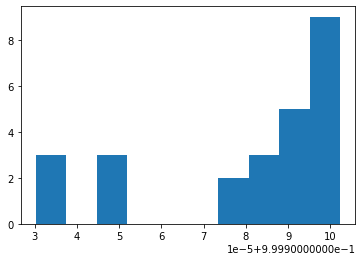

In [40]:
plt.hist(alphas[:, 0])

In [41]:
np.std(alphas[:, 0])

2.34567519547567e-05

In [42]:
alphas[:, 0]

array([0.99999843, 0.99997965, 0.99999125, 0.99998612, 0.99999536,
       0.99993467, 0.99997959, 1.00000232, 0.99999245, 0.9999459 ,
       0.99994992, 0.99999812, 0.99998988, 0.99999069, 0.99999777,
       0.99993026, 0.99998532, 0.99999939, 0.99999993, 0.99998593,
       0.99999848, 0.99995022, 0.99993145, 0.99998972, 0.99999981])

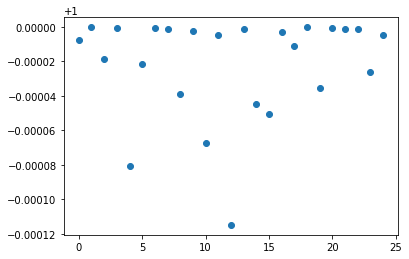

In [30]:
plt.scatter(np.arange(25), alphas[:, 0])

(0.5, 1.5)

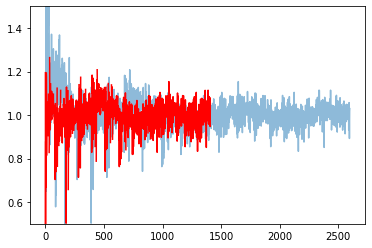

In [14]:
plt.plot(r, alpha=0.5)
plt.plot(lpost.sp(k[lpost.is_g], result.x), 'r')
plt.ylim(0.5, 1.5)

25
25
25
25
25
25


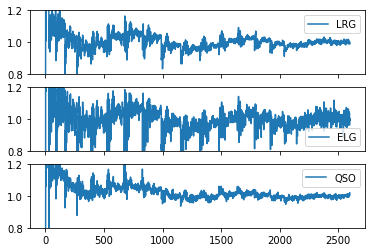

In [63]:
fig, ax = plt.subplots(nrows=3, sharex=True)

for i, tracer in enumerate(['LRG', 'ELG', 'QSO']):
    
    bk_lrg = read_spectra(glob(f'/Users/mehdi/data/AbacusData/bk_{tracer}*'))
    bk_lrg_smooth = read_spectra(glob(f'/Users/mehdi/data/Abacus_smooth/all_bk_{tracer}*'), iy=5)
    
    ax[i].plot(bk_lrg.y.mean(axis=0)/bk_lrg_smooth.y.mean(axis=0), label=tracer)
    ax[i].set_ylim(0.8, 1.2)
    ax[i].legend()

(0.5, 1.5)

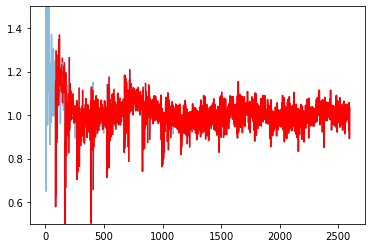

In [130]:
plt.plot(r, alpha=0.5)
plt.plot(sp(k, result.x), 'r')
plt.ylim(0.5, 1.5)

In [129]:
result.x

array([ 9.99992554e-01,  1.00006685e+00,  5.99676407e-05,  1.45085007e-04,
       -8.80192600e-05,  5.29581546e-04, -2.36323683e-06,  3.03462479e-04,
        2.68246495e-06, -5.80054391e-04,  8.09639005e-05])

In [117]:
for a in np.linspace(0.9, 1.1, 11):
    p = [a, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    print(a, nlogpost(p))

0.9 3.564736095172842
0.92 3.0797610848349146
0.9400000000000001 2.632174048482171
0.9600000000000001 1.8480587766918042
0.9800000000000001 0.6909532789837665
1.0 -0.0
1.02 0.6806387123149882
1.04 1.7097082339422012
1.06 2.3636706932660423
1.08 2.686779525306486
1.1 2.975514545221868


In [4]:
prepar = src.io.Preparer()

loading cache...
(15000, 30)
loading cache...
(15000, 2600)
Done reading Molino


In [6]:
prepar.prep('glam', 'gal')

creating cache with iy=1
(1097, 30)
creating cache with iy=1
(935, 30)
creating cache with iy=3
(1097, 2600)
creating cache with iy=3
(970, 2600)
Done writing mean and covariances for mock=glam and gal=gal


In [7]:
prepar.prep('abacus', 'lrg')

creating cache with iy=1
(25, 30)
creating cache with iy=2
(25, 30)
creating cache with iy=3
(25, 2600)
creating cache with iy=4
(25, 2600)
Done writing mean and covariances for mock=abacus and gal=lrg


## Plot data

In [8]:
pk_glam = src.io.Spectrum('./cache/glam_gal_pkmean.npz')
pks_glam = src.io.Spectrum('./cache/glam_gal_pksmoothmean.npz')
pk_abacus = src.io.Spectrum('./cache/abacus_lrg_pkmean.npz')
pks_abacus = src.io.Spectrum('./cache/abacus_lrg_pksmoothmean.npz')

bk_glam = src.io.Spectrum('./cache/glam_gal_bkmean.npz')
bks_glam = src.io.Spectrum('./cache/glam_gal_bksmoothmean.npz')
bk_abacus = src.io.Spectrum('./cache/abacus_lrg_bkmean.npz')
bks_abacus = src.io.Spectrum('./cache/abacus_lrg_bksmoothmean.npz')

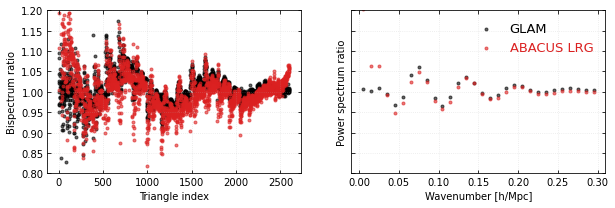

In [9]:
tix =  np.arange(bk_glam.x.shape[0])
src.plots.plot_spectra([(tix,   bk_glam.y/bks_glam.y),
                        (tix,   bk_abacus.y/bks_abacus.y)], 
                       [(pk_glam.x, pk_glam.y/pks_glam.y),
                        (pk_glam.x, pk_abacus.y/pks_abacus.y)],
                       ['GLAM', 'ABACUS LRG'])

In [26]:
bk_abacus = src.io.Spectrum('./cache/abacus_lrg_bkmean.npz')
bk_abacus_old = src.io.Spectrum('./cache27feb/bk_mean_abacus_bao.npz')

Text(0, 0.5, 'k1*k2*k3*B')

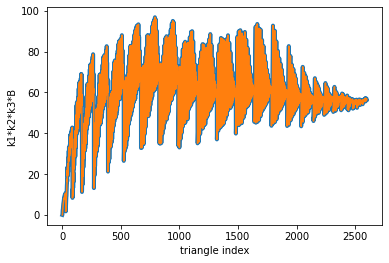

In [39]:
plt.plot(bk_abacus.x[:, 0]*bk_abacus.x[:, 1]*bk_abacus.x[:, 2]*bk_abacus.y, lw=4)
plt.plot(bk_abacus.x[:, 0]*bk_abacus.x[:, 1]*bk_abacus.x[:, 2]*bk_abacus_old.y)
plt.xlabel('triangle index')
plt.ylabel('k1*k2*k3*B')

## Test MCMC

0.03
0.03
0.03
0.03
0.03
0.03


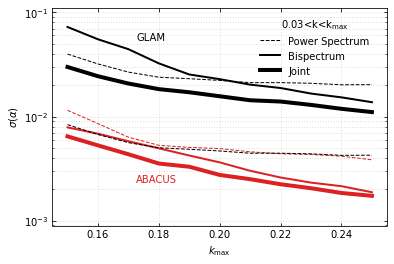

In [18]:
def plot_sigmakmax():
    
    kmax1, sigma1 = src.io.read_sigmas(glob('mcmc_feb27/pk_abacus_lrg_abacus_*.npz'))
    kmax2, sigma2 = src.io.read_sigmas(glob('mcmc_feb27/pk_glam_gal_glam_*.npz'))
    kmax3, sigma3 = src.io.read_sigmas(glob('mcmc_jan31/bk_abacus_abacus_*.npz'))
    kmax4, sigma4 = src.io.read_sigmas(glob('mcmc_jan31/bk_glam_glam_*.npz'))
    kmax5, sigma5 = src.io.read_sigmas(glob('mcmc_jan31/pb_abacus_abacus_*.npz'))
    kmax6, sigma6 = src.io.read_sigmas(glob('mcmc_jan31/pb_glam_glam_*.npz'))
    
    fg, ax = plt.subplots()
    
    ax.plot(kmax2, sigma2, color='#000000', lw=1, label='Power Spectrum', ls='--')
    ax.plot(kmax4, sigma4, color='#000000', lw=2, label='Bispectrum')
    ax.plot(kmax6, sigma6, color='#000000', lw=4, label='Joint')

    ax.plot(kmax1, sigma1, color='#db2121', lw=1, ls='--')
    ax.plot(kmax3, sigma3, color='#db2121', lw=2)
    ax.plot(kmax5, sigma5, color='#db2121', lw=4)
    ax.plot(kmax2, sigma2/np.sqrt(8**1.5), color='#000000', lw=1, ls='--')

    lgn = fg.legend(title=r'0.03<k<k$_{\rm max}$', bbox_to_anchor=(0.88, 0.88), frameon=False)        
    ax.set(xlabel=r'$k_{\rm max}$', ylabel=r'$\sigma (\alpha)$', yscale='log', ylim=(9.0e-4, 1.1e-1))
    ax.tick_params(direction='in', right=True, top=True, which='both', axis='both')
    ax.grid(True, ls=':', lw=1, which='both', alpha=0.4)    
    ax.text(0.25, 0.85, 'GLAM', transform=ax.transAxes)
    ax.text(0.25, 0.2, 'ABACUS', color='#db2121', transform=ax.transAxes)    
    fg.savefig('../bisp4desi/figures/sigma_kmax.pdf', bbox_inches='tight')   
    
plot_sigmakmax()

In [9]:
chi2s = {}
for s in ['glam', 'abacus']:
    for p in ['pk', 'bk']:
        chi2s[f'{s}_{p}'] = read_chi2list(np.sort(glob(f'mcmc_jan31/{p}_{s}_{s}_*.npz')))

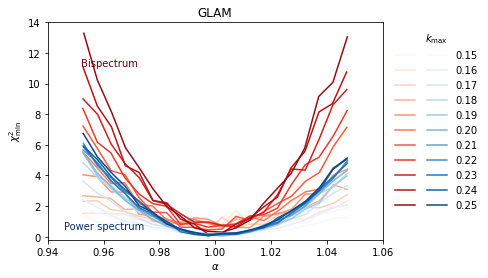

In [10]:
src.plots.plot_chi2(chi2s['glam_bk'], chi2s['glam_pk'], title='GLAM')

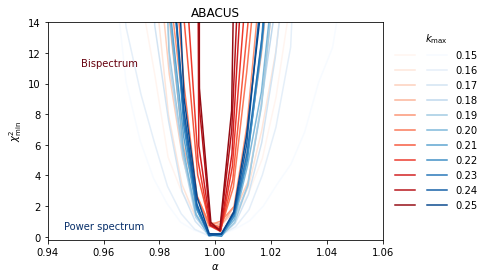

In [11]:
src.plots.plot_chi2(chi2s['abacus_bk'], chi2s['abacus_pk'], title='ABACUS')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [82]:
def plot_detection(s, km='0.250'):    
    d1 = np.load(f'mcmc_jan31/pk_{s}_{s}_0.030_{km}.npz')
    d2 = np.load(f'mcmc_jan31/bk_{s}_{s}_0.030_{km}.npz')
    d3 = np.load(f'mcmc_jan31/pb_{s}_{s}_0.030_{km}.npz')

    fig, ax = plt.subplots()
    alpha_edge = np.linspace(0.95, 1.05, num=21)

    ls = ['--', '-', '-']
    lw = [1, 2, 4]

    for i, (di, ni) in enumerate(zip([d1, d2, d3],
                                     ['Power Spectrum', 'Bispectrum', 'Joint'])):
        x = di['chain'][5000:, :, 0].flatten()
        y = -2.*di['log_prob'][5000:, :].flatten()
        print(y.min())
        ym = binned_statistic(x, y, statistic=np.min, bins=alpha_edge)[0]
        xm = binned_statistic(x, x, statistic=np.mean, bins=alpha_edge)[0]
        ax.plot(xm, ym, label=ni, ls=ls[i], color='#000000', alpha=0.8, lw=lw[i])
        
    leg = ax.legend(frameon=False, title=fr'$0.03<k<{km}$')
    ax.set(xlabel=r'$\alpha$', ylabel=r'$\chi^{2}_{\rm min}$', title=s.upper(), 
           ylim=(-0.2, 14), xlim=(0.94, 1.06))
    fig.savefig(f'../bisp4desi/figures/chi2alpha_{s}.pdf', bbox_inches='tight')

0.177504177320562
0.7644025550586349
1.2842154629033131


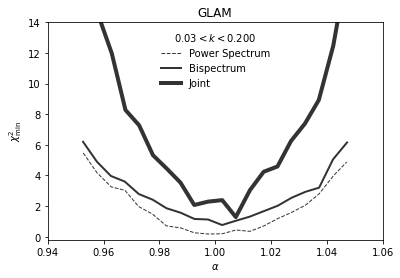

In [88]:
plot_detection('glam', '0.200')

0.12390150304562333
0.8977478643033432
2.545098892381207


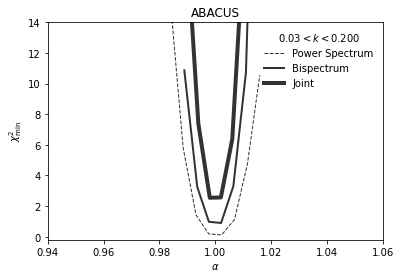

In [89]:
plot_detection('abacus', '0.200')

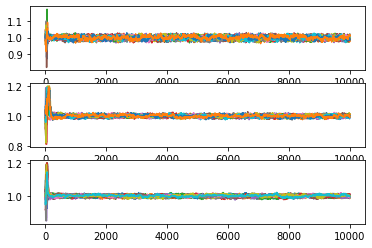

In [62]:
s = 'abacus'
km = '0.160'
d1 = np.load(f'mcmc_jan31/pk_{s}_{s}_0.030_{km}.npz')
d2 = np.load(f'mcmc_jan31/bk_{s}_{s}_0.030_{km}.npz')
d3 = np.load(f'mcmc_jan31/pb_{s}_{s}_0.030_{km}.npz')

fg, ax = plt.subplots(nrows=3)
for i, di in enumerate([d1, d2, d3]):    
    ax[i].plot(di['chain'][:, :, 0])



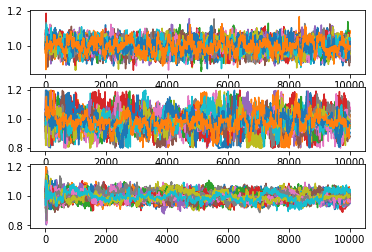

In [51]:
s = 'glam'
km = '0.160'
d1 = np.load(f'mcmc_jan31/pk_{s}_{s}_0.030_{km}.npz')
d2 = np.load(f'mcmc_jan31/bk_{s}_{s}_0.030_{km}.npz')
d3 = np.load(f'mcmc_jan31/pb_{s}_{s}_0.030_{km}.npz')

fg, ax = plt.subplots(nrows=3)
for i, di in enumerate([d1, d2, d3]):    
    ax[i].plot(di['chain'][:, :, 0])


In [3]:
dl = DataLoader()

In [4]:
k, pk_glam = dl.load('glam_pk_bao', 1)
__, pk_glam_nobao = dl.load('glam_pk_nobao', 1)
__, pk_molino = dl.load('molino_pk', 1)

k3, bk_glam = dl.load('glam_bk_bao', 3)
__, bk_glam_nobao = dl.load('glam_bk_nobao', 3)
__, bk_molino = dl.load('molino_bk', 3)

loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)


In [11]:
c_g = np.column_stack([pk_glam/pk_glam_nobao.mean(axis=0), bk_glam/bk_glam_nobao.mean(axis=0)])
c_m = np.column_stack([pk_molino, bk_molino])
c_g.shape, c_m.shape

((1097, 2630), (15000, 2630))

In [36]:
class A(object):
    def __init__(self, v):
        self.a = v
    def __call__(self, x):
        return self.a+x
    
class B(object):
    def __init__(self, v):
        self.a = v
    def __call__(self, x):
        return self.a-x 
    
    
class D(A, B):
    def __init__(self, v1, v2):
        A.__init__(self, v1)
        B.__init__(self, v2)
    
    def __call__(self, x1, x2):
        c1 = A.__call__(self, x1)
        c2 = B.__call__(self, x2)
        return (c1, c2)

In [37]:
a = A(12)
b = B(12)

In [38]:
d = D(12, 12)

In [39]:
d(2, 3)

(14, 9)

In [40]:
a(2), b(3)

(14, 9)

(0.8, 1.2)

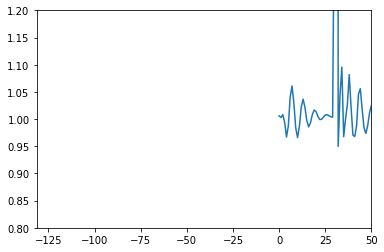

In [10]:
plt.plot(c.mean(axis=0))
plt.xlim(xmax=50)
plt.ylim(0.8, 1.2)

In [27]:
def gelman_rubin(chain):
    # chain: #steps, #chain
    ssq = np.var(chain, axis=0, ddof=1) 
    W = np.mean(ssq, axis=0)   # within chain var
    pb = np.mean(chain, axis=0)
    pbb = np.mean(pb, axis=0)

    n = chain.shape[0]
    m = chain.shape[1]    
    B = n / (m - 1) * np.sum((pbb - pb)**2, axis=0) # between chain var
    var_p = (n - 1) / n * W + 1 / n * B
    rhat = np.sqrt(var_p / W)
    return rhat

In [30]:
gelman_rubin(d_['chain'][:1000, :, 0])

1.0088613431756197

In [25]:
d_['chain'][5000:, :, 0].shape

(5000, 22)

[0.96224234 1.06423153]
[0.69675414 1.54220246]
[-6.0835285   4.74141155]
[-40.67944398  47.81204999]
[-0.23482382  0.26914284]
[-142.23198506  120.46243245]
[-0.0044365   0.00392685]


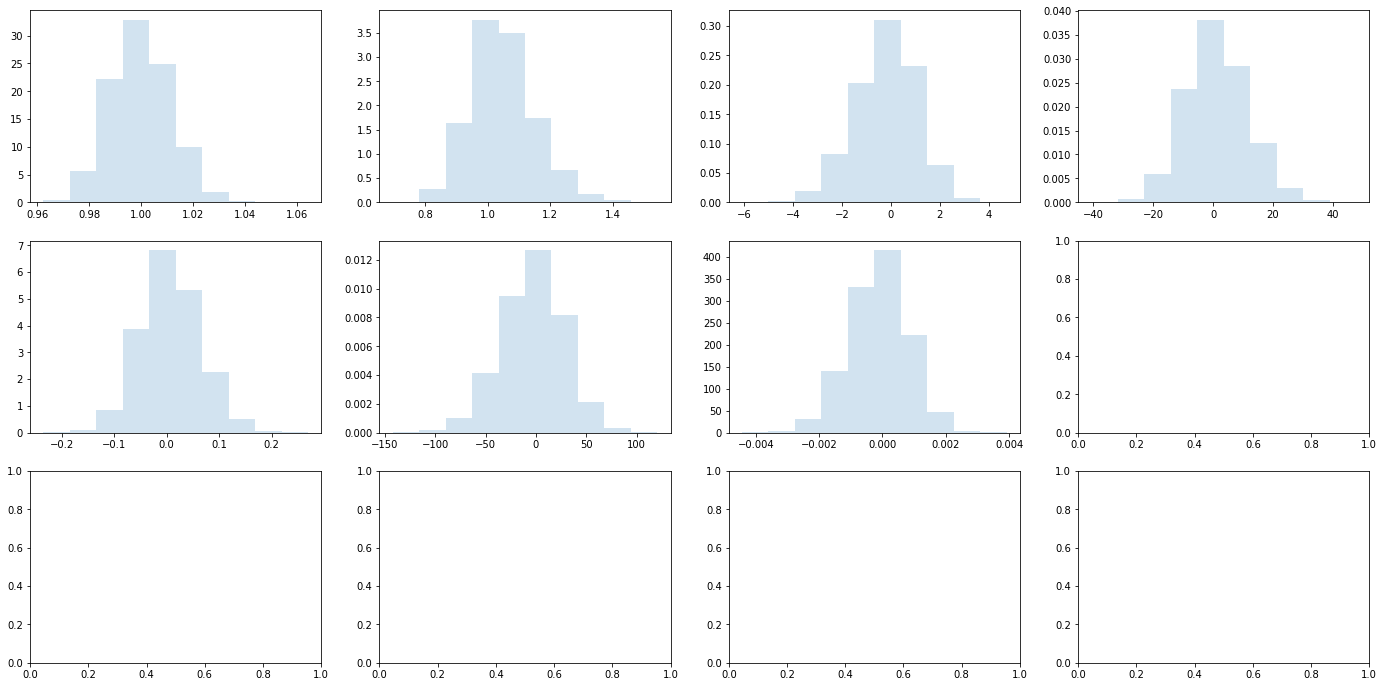

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
ax = ax.flatten()

for i in range(d_['chain'].shape[-1]):
    # ax[i].hist(d['chain'][5000:, :, i].flatten(), alpha=0.2, density=True)
    ax[i].hist(d_['chain'][5000:, :, i].flatten(), alpha=0.2, density=True)
    print(np.percentile(d_['chain'][5000:, :, i].flatten(), [0, 100]))
    

Text(0.5, 0, 'wavenumber [h/Mpc]')

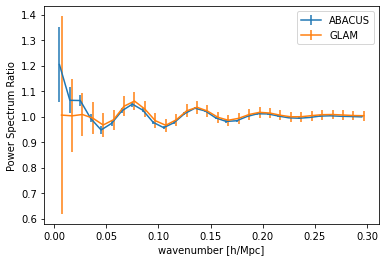

In [18]:
i = 0
for mock in ['abacus', 'glam']:
    
    stat = 'pk'
    # mock = 'abacus'
    temp = mock
    y = Spectrum(f'cache/{stat}_mean_{mock}_bao.npz')
    ys = Spectrum(f'cache/{stat}_mean_{temp}_nobao.npz')
    cov = Spectrum(f'cache/{stat}_cov_{mock}_bao.npz')
    plt.errorbar(y.x+0.002*i, y.y/ys.y, yerr=np.diagonal(cov.y)**0.5, label=mock.upper())
    i += 1
plt.legend()
plt.ylabel('Power Spectrum Ratio')
plt.xlabel('wavenumber [h/Mpc]')

In [17]:
y.x

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295])

In [5]:
is_g = (y.x > 0.015) & (y.x < 0.13) 
is_g = is_g.sum(axis=1) == 3

x_g = y.x[is_g]
r_g = (y.y/ys.y)[is_g]
c_g = cov.y[is_g,:,][:, is_g]
ic_g = np.linalg.inv(c_g)

In [9]:
from src.models import BiSpectrum

In [10]:
r_int = BiSpectrum(y.x, y.y/ys.y)

In [29]:
def loglike(p):
    res = r_g - r_int(x_g, p)
    is_ok = ~np.isnan(res)    
    #if is_ok.sum() ==0:
    #    return -np.inf
    #else:            
    return  -0.5*res[is_ok].dot(ic_g[is_ok, :][:, is_ok].dot(res[is_ok]))

def logprior(p):
    lp = 0.
    lp += 0. if  0.9 < p[0] < 1.1 else -np.inf
    lp += 0. if  0.8 < p[1] < 1.2 else -np.inf    
    for p_i in p[2:]:
        lp += 0. if  -1 < p_i < 1. else -np.inf
    return lp

def logpost(p):
    return loglike(p) + logprior(p)

def nlogpost(p):
    return -1.*logpost(p)

In [30]:
guess = np.array([1.001, 1.001, 1.1e-5, 1.2e-5, 1.3e-5, 1.1e-5, 1.2e-5, 1.3e-5, 1.0e-5, 0.9e-5, 1.1e-5])
start = (guess + guess*0.02*np.random.randn(50, 11))

In [31]:
for s in start:
    print(logpost(s))

-0.019408861842226496
-0.007620845077150634
-0.007888390203940148
-0.008862727394702438
-0.0024373891472734568
-0.01406453427391325
-0.017468073171336744
-0.0901179160143377
-0.0023148334411223475
-0.020863976518058932
-0.034029590589402275
-0.008627994620870622
-0.002027414006793732
-0.007155820757474676
-0.005916715661599145
-0.0031888498545395083
-0.026194485193954536
-0.009948746348104914
-0.004950925198240695
-0.0030730159466689374
-0.002608491247113996
-0.013832275991846894
-0.01014591490436914
-0.017581117210251573
-0.018327415319419213
-0.00800648592484167
-0.009829408943324135
-0.03152695528977704
-0.06331713761471565
-0.013110156783927913
-0.01415095152754359
-0.01224262929471479
-0.010791320474832326
-0.054848706455694604
-0.021607669673610247
-0.013293553227040206
-0.003061372293617159
-0.0006656195760880825
-0.001774707942634408
-0.018009694934513945
-0.009454128082254858
-0.010761348131810008
-0.10845174738823338
-0.030046678096103747
-0.0014945713867181255
-0.00276594295

In [ ]:
#     vr = 8
#     p = 1.5
#     ax[2].plot(bk_abacus.var(axis=0)/p3_abacus*vr**p, label='ABACUS', alpha=0.8)
#     ax[2].plot(bk_glam.var(axis=0)/p3_glam,           label='GLAM')
#     ax[2].plot(bk_molino.var(axis=0)/p3_molino,       label='MOLINO')
#     ax[3].plot(k, pk_abacus.var(axis=0)/pk_abacus.mean(axis=0)**2*vr**p, label='ABACUS')
#     ax[3].plot(k, pk_glam.var(axis=0)/pk_glam.mean(axis=0)**2,           label='GLAM')
#     ax[3].plot(k, pk_molino.var(axis=0)/pk_molino.mean(axis=0)**2,       label='MOLINO')
#     ax[2].set(xlabel='Triangle index', yscale='log', 
#               ylabel='Normalized bispectrum dispersion')#, ylabel=r'$\frac{\sigma^{2}_{B}}{P^{3}V^{1.5}}$')
#     ax[3].legend(bbox_to_anchor=(-1, 2.1, 1.5, 0.15), 
#                  mode='expand', ncol=3, frameon=False, fontsize=13)    
#     # fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
#     # ax[0].set(ylabel=r'$\chi^{2}(\alpha)$', xlabel=r'$\alpha$', title='Scoccimaro template')
#     # ax[1].set(xlabel=r'$\alpha$', title='GLAM template')
#     # # different curves for different k-max values

#     # fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    # ax[0].set(xlabel='Triangle index', title='GLAM', ylabel='Bispectrum ratio')
    # ax[1].set(xlabel=r'kmax', title='GLAM', ylabel=r'$\sigma(\alpha)$')      

In [11]:
pk_glam_bao.x, pk_glam_bao.y

(array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
        0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
        0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
        0.275, 0.285, 0.295]),
 array([13.30533495, 12.26090917,  9.8172015 ,  7.718056  ,  6.04934489,
         5.11676342,  4.53520081,  3.95469598,  3.29829311,  2.75108726,
         2.37053697,  2.14782723,  1.98742684,  1.81072653,  1.61351515,
         1.43488749,  1.29848154,  1.20190007,  1.12622522,  1.052373  ,
         0.97680565,  0.90427197,  0.84115018,  0.78982083,  0.74668514,
         0.70710681,  0.66898349,  0.63290016,  0.59951996,  0.56984191]))

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295])

In [ ]:
k, pk_glam = dl.load('glam_pk_bao', 1)
__, pk_glam_nobao = dl.load('glam_pk_nobao', 1)
__, pk_molino = dl.load('molino_pk', 1)
__, pk_abacus = dl.load('abacus_pk', 1)
__, pk_abacus_nobao = dl.load('abacus_pk_nobao', 2)

k3, bk_glam = dl.load('glam_bk_bao', 3)
__, bk_glam_nobao = dl.load('glam_bk_nobao', 3)
__, bk_molino = dl.load('molino_bk', 3)
__, bk_abacus = dl.load('abacus_bk', 3)
__, bk_abacus_nobao = dl.load('abacus_bk_nobao', 4)

p3_abacus = get_p3(k3, pk_abacus.mean(axis=0))
p3_molino = get_p3(k3, pk_molino.mean(axis=0))
p3_glam   = get_p3(k3, pk_glam.mean(axis=0))



loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(25, 30)
loading cache...
(25, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)
loading cache...
(25, 2600)
loading cache...
(25, 2600)


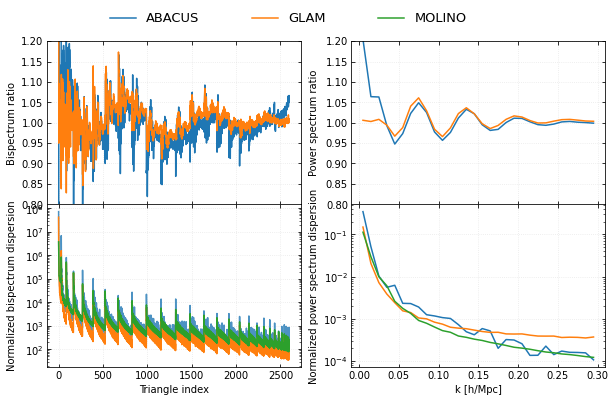

In [5]:
plot_spectra(dl)

loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(25, 30)
loading cache...
(25, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)
loading cache...
(25, 2600)
loading cache...
(25, 2600)


In [7]:
# C_P ~ var(P)/(P^{2}V^p)  # p = 1.5
# C_B ~ var(B)/(P^{3}V^p)

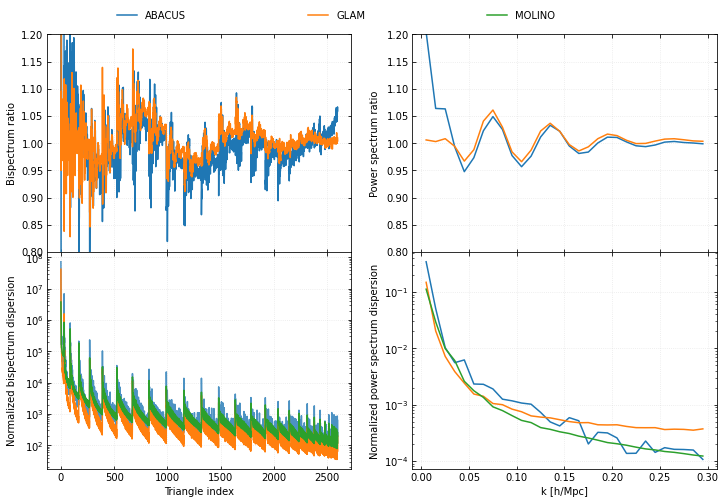

In [8]:
rcov_p = get_cov(pk_molino)
rcov_b = get_cov(bk_molino)

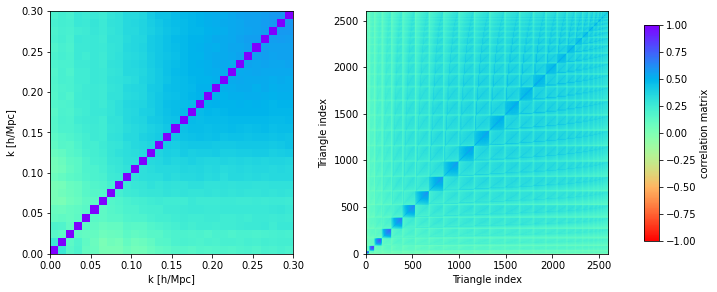

In [10]:
plot_rcov(rcov_p, rcov_b)

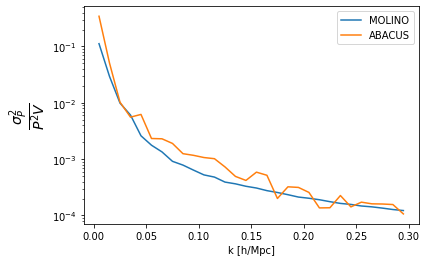

In [2]:
%matplotlib inline

In [3]:
import helpers as hp

In [5]:
bk_a = hp.read_abacus_bk()
bk_g = hp.read_glam_bk()
bk_gs = hp.read_glam_bk_nobao()

In [21]:
files = glob('/mnt/data1/Abacus_All/all_pk_LRGz0_8000.txtall_bk_LRGz0_*.txt')
# d = np.loadtxt('/mnt/data1/Abacus_All/all_bispectrum/all_bk_LRGz0_8000.txt').T
# d.shape
print(len(files))
y_1 = []
for file_i in files:
    d_ = np.loadtxt(file_i).T
    y_1.append(d_[4, :])
bk_as = np.mean(y_1, axis=0)

25


In [27]:
bk_g['pk'].shape

(1097, 2600)

In [15]:
bk_a['pk'].shape

(25, 2600, 3)

Text(0, 0.5, 'Bispectrum Ratio')

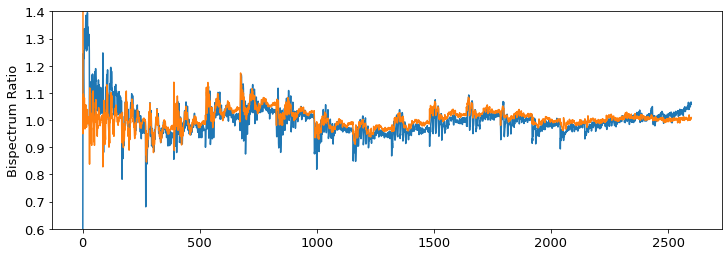

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(bk_a['pk'][:, :, 0].mean(axis=0)/bk_as)
plt.plot(bk_g['pk'].mean(axis=0)/bk_gs['pk'].mean(axis=0))
plt.ylim(0.6, 1.4)
plt.ylabel('Bispectrum Ratio')

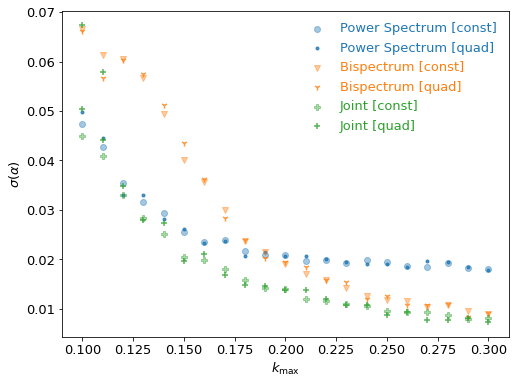

In [3]:
plot_sigma_kmax()

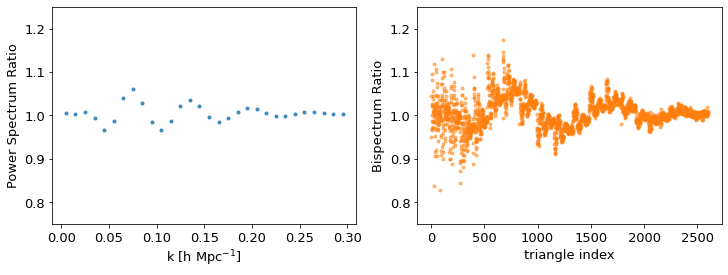

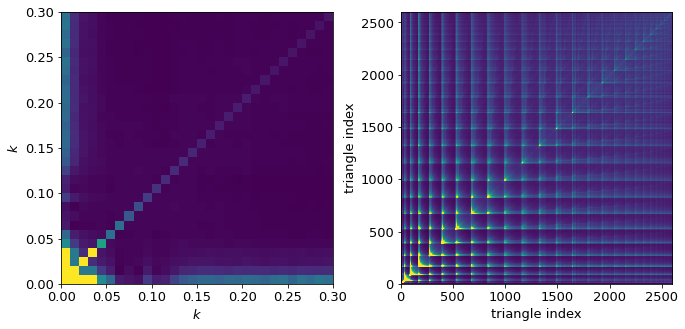

In [4]:
plot_spectra_glam()

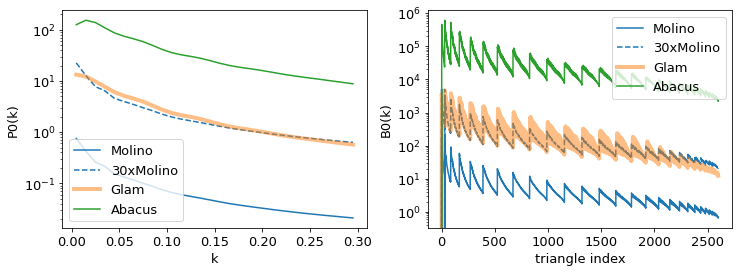

In [5]:
plot_spectra()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


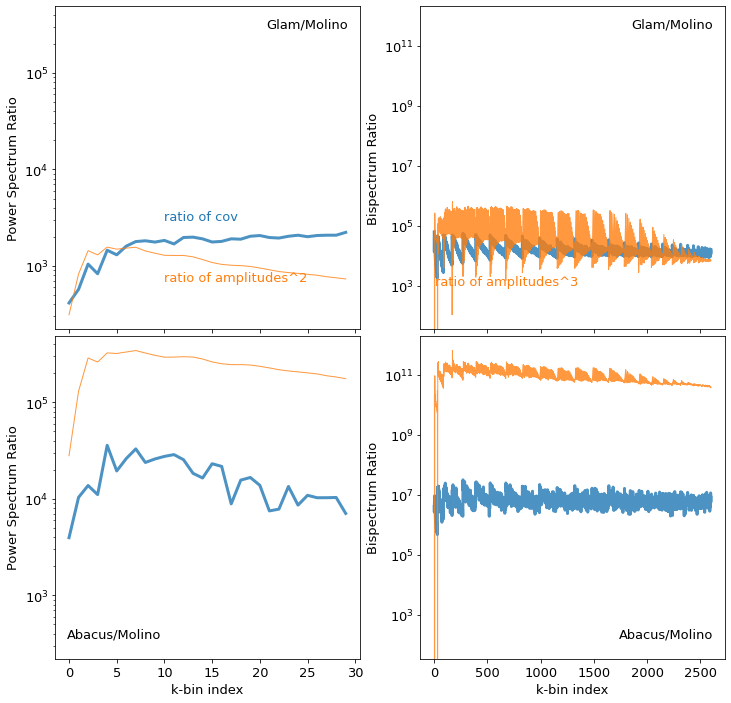

In [13]:
plot_ratios()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


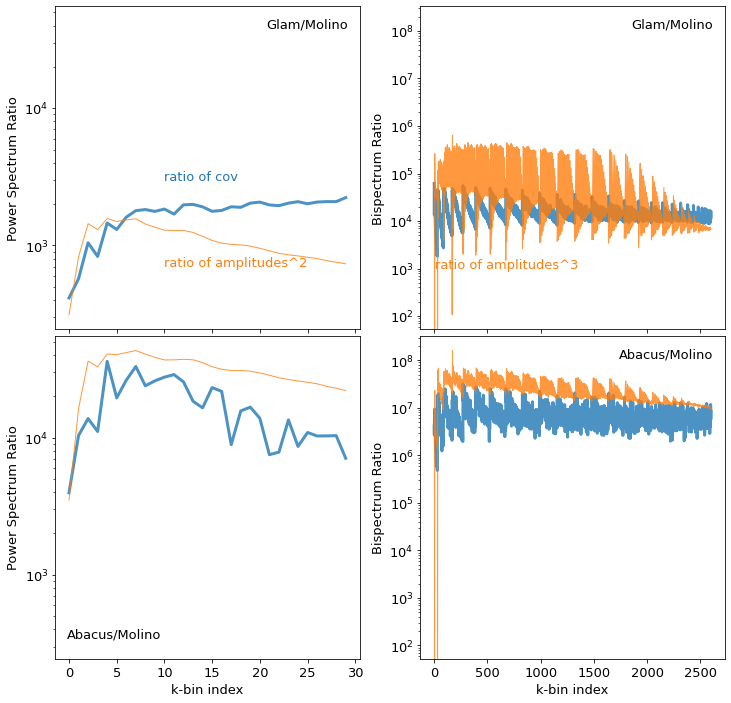

In [7]:
plot_ratios()

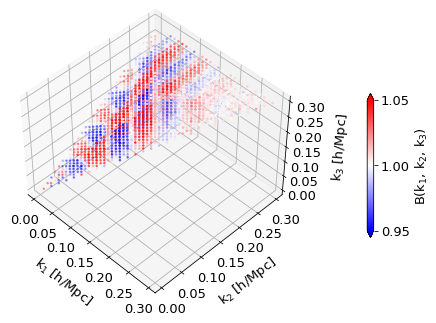

In [7]:
plot_glambk()

In [ ]:
# compare the ratio of covariance (diagonal) to the ratio of amplitudes
# Abacus variance is more sensitive to # of realizations rather than the amplitude